# CREA-CI historical phenotypic wheat data analysis

## Load packages and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

Online License checked out Thu Nov  9 15:37:38 2023


In [2]:
data_file <- "CREA-historic.xlsx"
experiments <- read_xlsx(data_file, sheet = "Experiment") |> rename_with(~tolower(gsub(" ", "_", .x)))
observations <- read_xlsx(data_file, sheet = "Observed scores") |> rename_with(~tolower(gsub(" ", "_", .x)))
glimpse(observations)

Rows: 7,979
Columns: 15
$ experiment_id            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ instcode                 <chr> "ITA383", "ITA383", "ITA383", "ITA383", "ITA3…
$ genus                    <chr> "Triticum", "Triticum", "Triticum", "Triticum…
$ accenumb                 <chr> "TA00004", "TA00018", "TA00025", "TA00087", "…
$ agent_id                 <chr> "AW_08340", "AW_08341", "AW_08342", "AW_08343…
$ doi                      <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ days_to_heading          <dbl> 125, 131, 123, 127, 125, 125, 130, 128, 126, …
$ plant_height             <dbl> 68, 108, 118, 114, 111, 117, 82, 65, 78, 82, …
$ thousand_kernel_weight   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ powdery_mildew           <dbl> 0, 2, 2, 2, 0, 2, 7, 0, 0, 0, 2, 0, 2, 7, 0, …
$ leaf_rust                <dbl> 0, 4, 2, 2, 2, 4, 2, 0, 0, 0, 0, 7, 4, 4, 2, …
$ yellow_rust              <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ septoria_triti

In [3]:
CREA_wheat <- observations |>
                left_join(experiments, by = "experiment_id") |>
                unite("campaign", c(year_start,year_end), sep="-") |>
                select(accenumb, campaign, days_to_heading, plant_height, thousand_kernel_weight) |>
                drop_na(accenumb, campaign) |> distinct() |> arrange(campaign, accenumb)
write_csv(CREA_wheat, "CREA_wheat.csv")
glimpse(CREA_wheat)

Rows: 7,931
Columns: 5
$ accenumb               <chr> "TA00001", "TA00001", "TA00001", "TA00001", "TA…
$ campaign               <chr> "2005-2006", "2005-2006", "2005-2006", "2005-20…
$ days_to_heading        <dbl> 128, 127, 127, 127, 127, 126, 125, 122, 129, 12…
$ plant_height           <dbl> 74, 84, 78, 80, 66, 68, 68, 92, 85, 116, 80, 75…
$ thousand_kernel_weight <dbl> 47.5, 45.8, 46.1, 47.2, 49.3, NA, NA, NA, NA, N…


In [4]:
data_total <- CREA_wheat
genotypes <- distinct(data_total["accenumb"]) |> rename("genotype" = "accenumb")
cat(sprintf("%i observations \n%i genotypes \n%i campaigns \n\nSummary of AGENT traits values:",
            nrow(data_total), nrow(genotypes), nrow(distinct(data_total["campaign"]))))
summary(data_total[3:5])

7931 observations 
1473 genotypes 
15 campaigns 

Summary of AGENT traits values:

 days_to_heading  plant_height    thousand_kernel_weight
 Min.   : 89.0   Min.   :  0.00   Min.   :11.00         
 1st Qu.:119.0   1st Qu.: 76.00   1st Qu.:38.50         
 Median :124.0   Median : 92.00   Median :44.00         
 Mean   :125.2   Mean   : 96.28   Mean   :43.67         
 3rd Qu.:130.0   3rd Qu.:114.00   3rd Qu.:49.50         
 Max.   :226.0   Max.   :406.00   Max.   :83.80         
 NA's   :14      NA's   :53       NA's   :4592          

## Remove singletons, make factors, exclude main outliers

In [5]:
make_data_sub <- function(full_df, trait){
                    full_df |> select("accenumb", "campaign", all_of(trait)) |> drop_na() |> 
                    group_by(accenumb) |> filter(n()>1) |>
                    group_by(campaign) |> filter(n()>1) |> 
                    mutate_at(vars(accenumb, campaign), factor) |> 
                    as.data.frame()}

data_sub_HT <- data_total |> filter(between(days_to_heading, 80, 200)) |> make_data_sub("days_to_heading")
data_sub_PH <- data_total |> filter(between(plant_height, 25, 300)) |> make_data_sub("plant_height")
data_sub_TKW <- data_total |> filter(between(thousand_kernel_weight, 10, 90)) |> make_data_sub("thousand_kernel_weight")

cat(sprintf("%i HT rows kept \n%i PH rows kept \n%i TKW rows kept \n", nrow(data_sub_HT), nrow(data_sub_PH), nrow(data_sub_TKW)))

7792 HT rows kept 
7746 PH rows kept 
3145 TKW rows kept 


## Visualise trait values 

In [6]:
options(repr.plot.width=8, repr.plot.height=6)
visualise_trait <- function(data_sub){
                    trait <- colnames(data_sub)[3]
                    trait_title <- trait |> str_replace_all("_", " ") |> str_to_title()
                    plot(ggplot(data_sub, aes(campaign,.data[[trait]])) + geom_jitter(na.rm=TRUE)
                         + theme(axis.text.x=element_text(angle=90,vjust=0.5,hjust=0.5))
                         + labs(title = trait_title, subtitle = "Trait values per campaign",))
                    plot(ggplot(data_sub, aes(.data[[trait]])) + geom_density(na.rm=TRUE)
                         + labs(title = trait_title, subtitle = "Distribution of trait values",))}

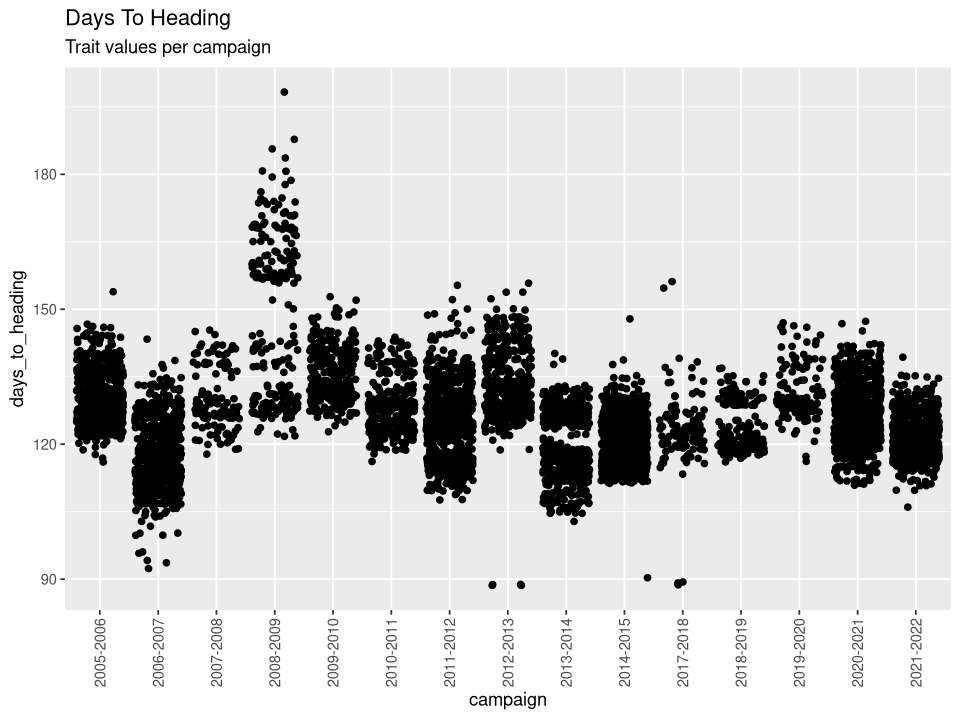

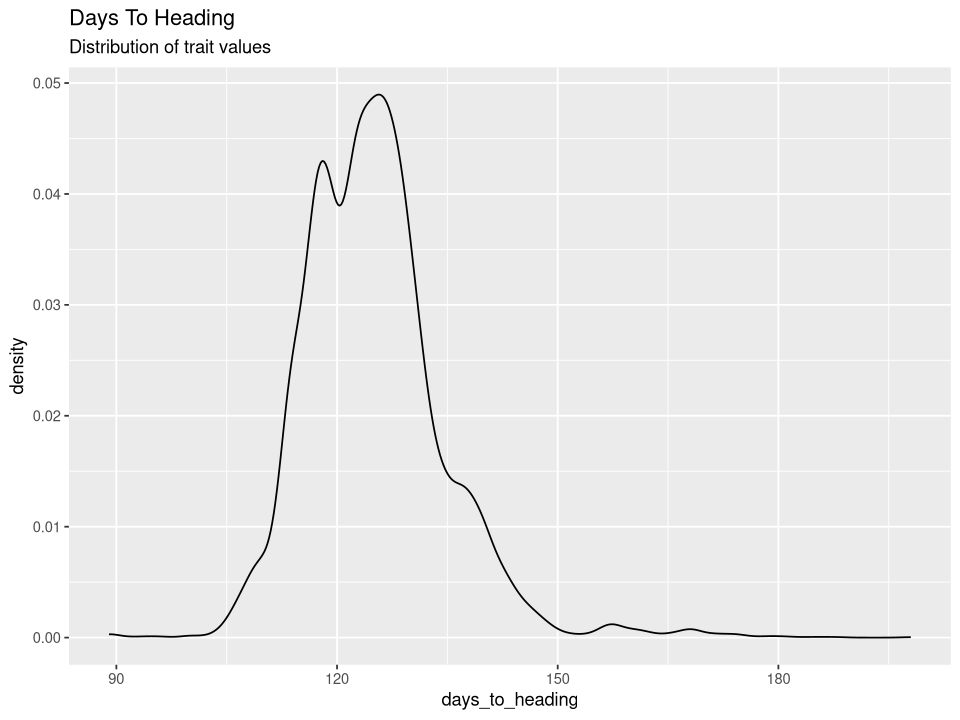

In [7]:
data_sub_HT |> visualise_trait()

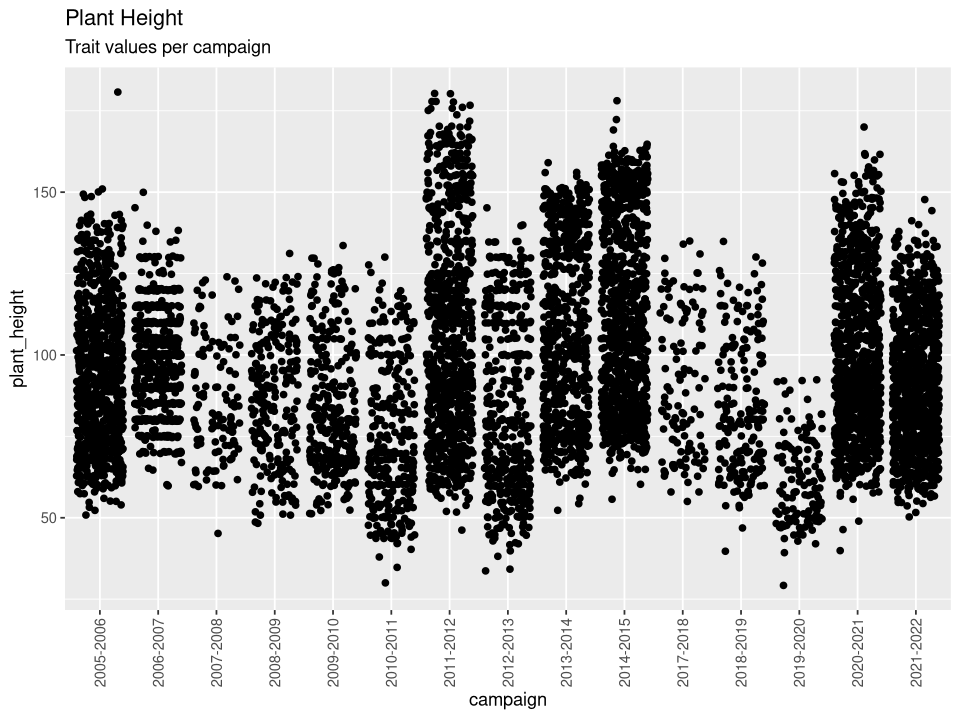

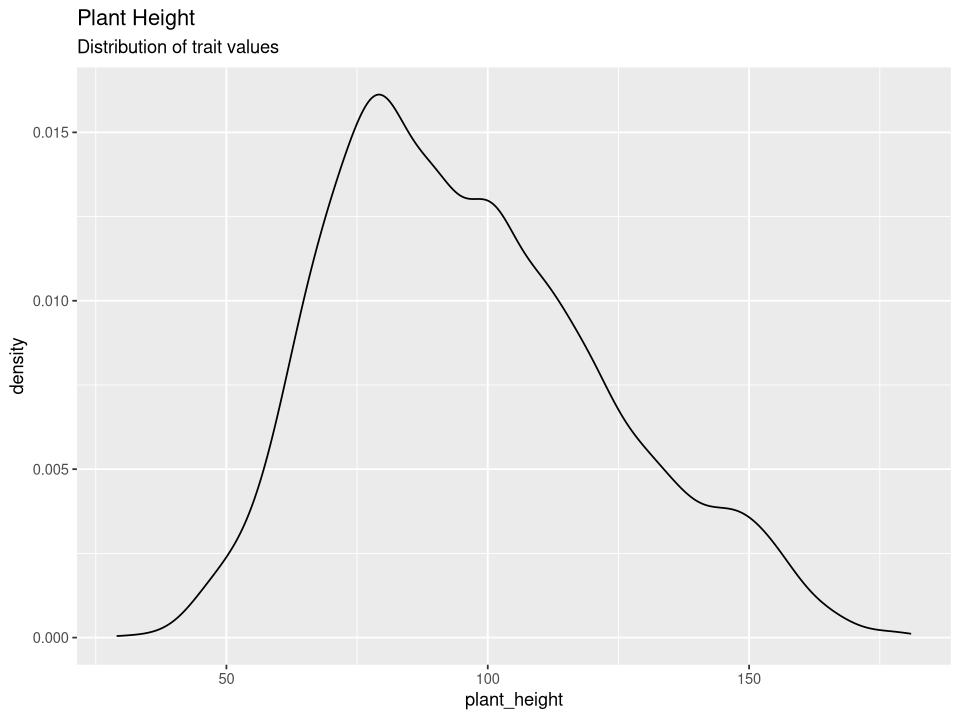

In [8]:
data_sub_PH |> visualise_trait()

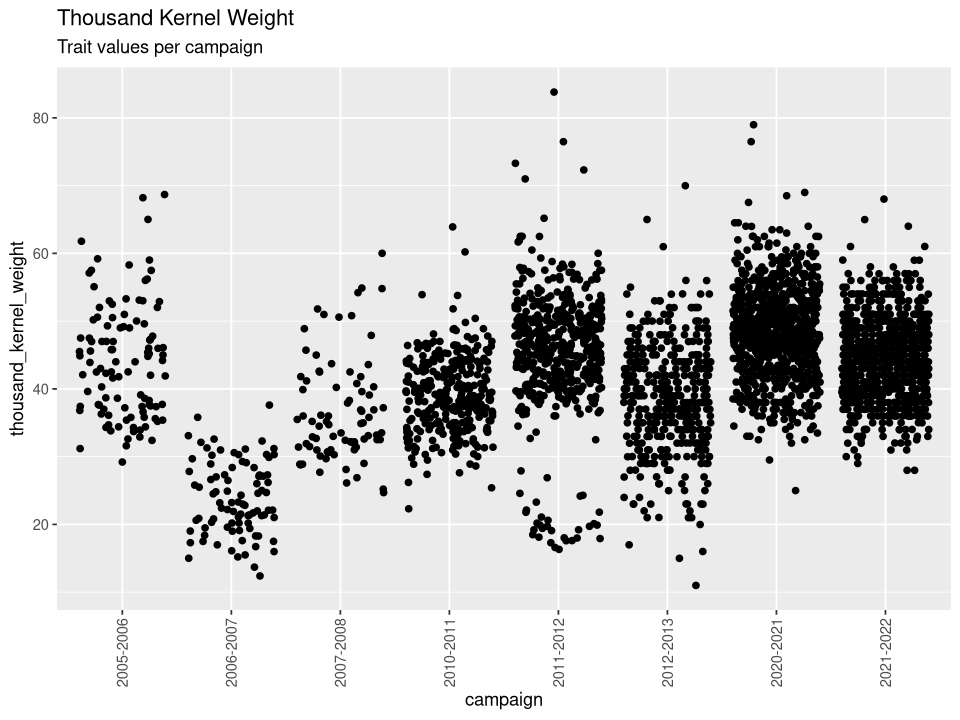

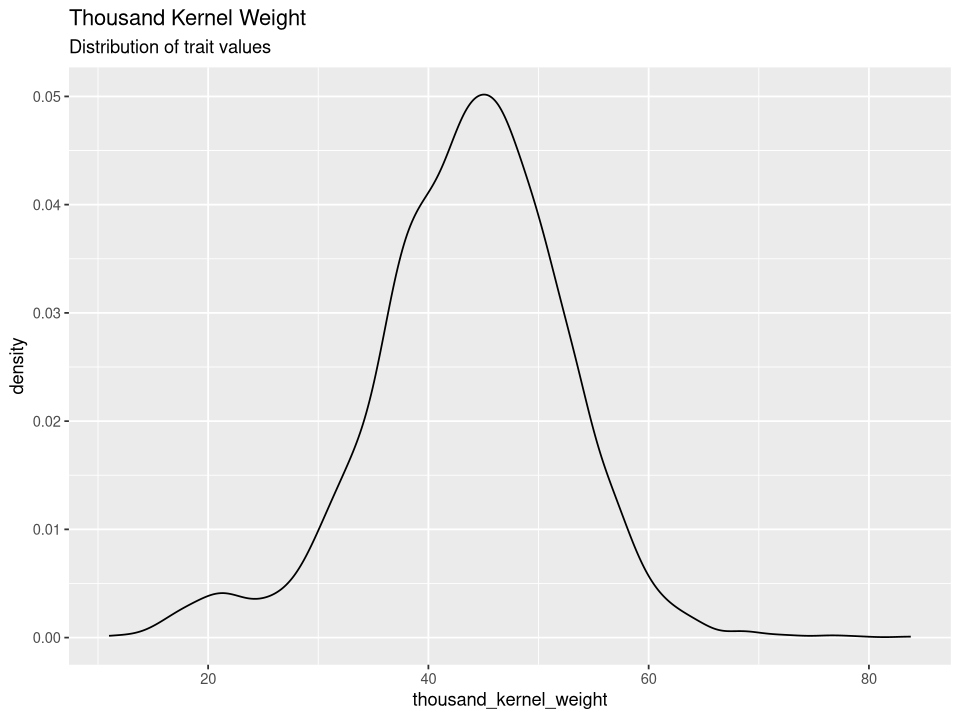

In [9]:
data_sub_TKW |> visualise_trait()

## Extract and format the campaign effects

In [10]:
asreml_campaign_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_HT)

Online License checked out Thu Nov  9 15:37:41 2023
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:41 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -16707.05           1.0   7777 15:37:41    0.0
 2     -15883.29           1.0   7777 15:37:41    0.0
 3     -15437.77           1.0   7777 15:37:41    0.0
 4     -15228.92           1.0   7777 15:37:41    0.0
 5     -15152.27           1.0   7777 15:37:41    0.0
 6     -15143.31           1.0   7777 15:37:41    0.0
 7     -15142.92           1.0   7777 15:37:41    0.0
 8     -15142.90           1.0   7777 15:37:41    0.0
 9     -15142.89           1.0   7777 15:37:41    0.0
10     -15142.89           1.0   7777 15:37:41    0.0


In [11]:
asreml_campaign_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PH)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:41 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -26593.99           1.0   7731 15:37:41    0.0
 2     -25609.37           1.0   7731 15:37:41    0.0
 3     -24586.87           1.0   7731 15:37:41    0.0
 4     -24115.06           1.0   7731 15:37:41    0.0
 5     -23901.75           1.0   7731 15:37:41    0.0
 6     -23862.32           1.0   7731 15:37:41    0.0
 7     -23859.41           1.0   7731 15:37:41    0.0
 8     -23859.33           1.0   7731 15:37:41    0.0
 9     -23859.33           1.0   7731 15:37:41    0.0


In [12]:
asreml_campaign_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_TKW)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:41 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -7526.728           1.0   3137 15:37:41    0.0
 2     -7346.827           1.0   3137 15:37:41    0.0
 3     -7156.827           1.0   3137 15:37:41    0.0
 4     -7049.599           1.0   3137 15:37:41    0.0
 5     -7016.236           1.0   3137 15:37:41    0.0
 6     -7013.636           1.0   3137 15:37:41    0.0
 7     -7013.575           1.0   3137 15:37:41    0.0
 8     -7013.573           1.0   3137 15:37:41    0.0


In [13]:
get_campaign_effect <- function(asreml_campaign){
                        intercept_index <- nrow(asreml_campaign$coeff$fixed)
                        intercept <- asreml_campaign$coeff$fixed[intercept_index]
                        campaign_effect <- asreml_campaign$coeff$fixed[-intercept_index,] + intercept
                        return(campaign_effect |> as.data.frame() |> rownames_to_column() |> 
                                mutate(campaign = str_sub(rowname,10)) |> 
                                select(campaign, campaign_effect))}

campaign_effect_HT <- get_campaign_effect(asreml_campaign_HT)
campaign_effect_PH <- get_campaign_effect(asreml_campaign_PH)
campaign_effect_TKW <- get_campaign_effect(asreml_campaign_TKW)

## Extract heterogeneous error variances

In [14]:
get_error_var <- function(asreml_campaign){
                    summary(asreml_campaign)$varcomp |> slice(2:n()) |> select(std.error) |> 
                    as_tibble() |> rename("error_variance"="std.error")}

error_var_HT <- get_error_var(asreml_campaign_HT)
error_var_PH <- get_error_var(asreml_campaign_PH)
error_var_TKW <- get_error_var(asreml_campaign_TKW)

## Calculate and standardize the coefficient of variation (CV)

In [15]:
make_CV_df <- function(campaign_effect, error_var){
                tibble(campaign_effect, error_var) |> 
                mutate(coefficient_of_variation=sqrt(error_variance)/campaign_effect) |> 
                mutate(standardized_CV=(coefficient_of_variation-mean(coefficient_of_variation)
                                       )/sd(coefficient_of_variation))}

CV_df_HT <- make_CV_df(campaign_effect_HT, error_var_HT)
CV_df_PH <- make_CV_df(campaign_effect_PH, error_var_PH)
CV_df_TKW <- make_CV_df(campaign_effect_TKW, error_var_TKW)

## Remove outlier campaigns

In [16]:
correct_I <- function(data_sub, CV_df){
                        outlier_campaigns <- CV_df |> filter(standardized_CV > 3.5) |> select(campaign)
                        return(data_sub |> filter(! campaign %in% outlier_campaigns))}

data_corrected_HT_I <- data_sub_HT |> correct_I(CV_df_HT)
data_corrected_PH_I <- data_sub_PH |> correct_I(CV_df_PH)
data_corrected_TKW_I <- data_sub_TKW |> correct_I(CV_df_TKW)

## Residuals

In [17]:
asreml_res_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_HT_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:42 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -13153.65           1.0   6444 15:37:43    0.8 (1 restrained)
 2     -12446.04           1.0   6444 15:37:43    0.5
 3     -12293.98           1.0   6444 15:37:44    0.5
 4     -12226.44           1.0   6444 15:37:44    0.5
 5     -12202.80           1.0   6444 15:37:45    0.5
 6     -12197.00           1.0   6444 15:37:45    0.5
 7     -12195.59           1.0   6444 15:37:46    0.5
 8     -12195.33           1.0   6444 15:37:46    0.5
 9     -12195.27           1.0   6444 15:37:47    0.5
10     -12195.26           1.0   6444 15:37:47    0.5
11     -12195.25           1.0   6444 15:37:48    0.5
12     -12195.25           1.0   6444 15:37:48    0.5


In [18]:
asreml_res_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PH_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:48 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -20818.02           1.0   6401 15:37:49    0.7 (4 restrained)
 2     -19726.59           1.0   6401 15:37:49    0.5
 3     -19383.45           1.0   6401 15:37:50    0.5
 4     -19208.53           1.0   6401 15:37:50    0.5
 5     -19154.30           1.0   6401 15:37:51    0.5
 6     -19150.00           1.0   6401 15:37:51    0.5
 7     -19149.91           1.0   6401 15:37:52    0.5
 8     -19149.91           1.0   6401 15:37:52    0.5


In [19]:
asreml_res_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_TKW_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:52 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -4910.343           1.0   2169 15:37:53    0.3
 2     -4856.405           1.0   2169 15:37:53    0.2
 3     -4822.419           1.0   2169 15:37:53    0.2
 4     -4810.776           1.0   2169 15:37:53    0.2
 5     -4806.130           1.0   2169 15:37:53    0.2
 6     -4804.858           1.0   2169 15:37:54    0.2
 7     -4804.614           1.0   2169 15:37:54    0.2
 8     -4804.597           1.0   2169 15:37:54    0.2
 9     -4804.597           1.0   2169 15:37:54    0.2


In [20]:
make_BH_multtest <- function(asreml_res){
            trait_title <- colnames(asreml_res$mf)[3] |> str_replace_all("_", " ") |> str_to_title()
            residual <- asreml_res$residuals
            MAD <- 1.4826*median(abs(residual-median(residual))) #approx constant https://en.wikipedia.org/wiki/Median_absolute_deviation#Relation_to_standard_deviation
            rawp_BHStud <- 2 * (1 - pnorm(abs(residual/MAD)))
            test_BHStud <- mt.rawp2adjp(rawp_BHStud, proc=c("Holm"))
            result_df <- tibble(adjp=test_BHStud[[1]][,1], bholm=test_BHStud[[1]][,2], index=test_BHStud[[2]]) |>
                    mutate(is_outlier = bholm < 0.05) |> arrange(index) |> mutate(std_residual = scale(residual))
            plot(ggplot(result_df, aes(index,std_residual, color=is_outlier)) + geom_jitter()
                 + scale_colour_manual(values = c("TRUE" = "#A51D2D", "FALSE" = "#26A269"))
                 + labs(title = trait_title, subtitle = "Outlier detection with Bonferroni–Holm method"))
            return(result_df |> as.data.frame())}

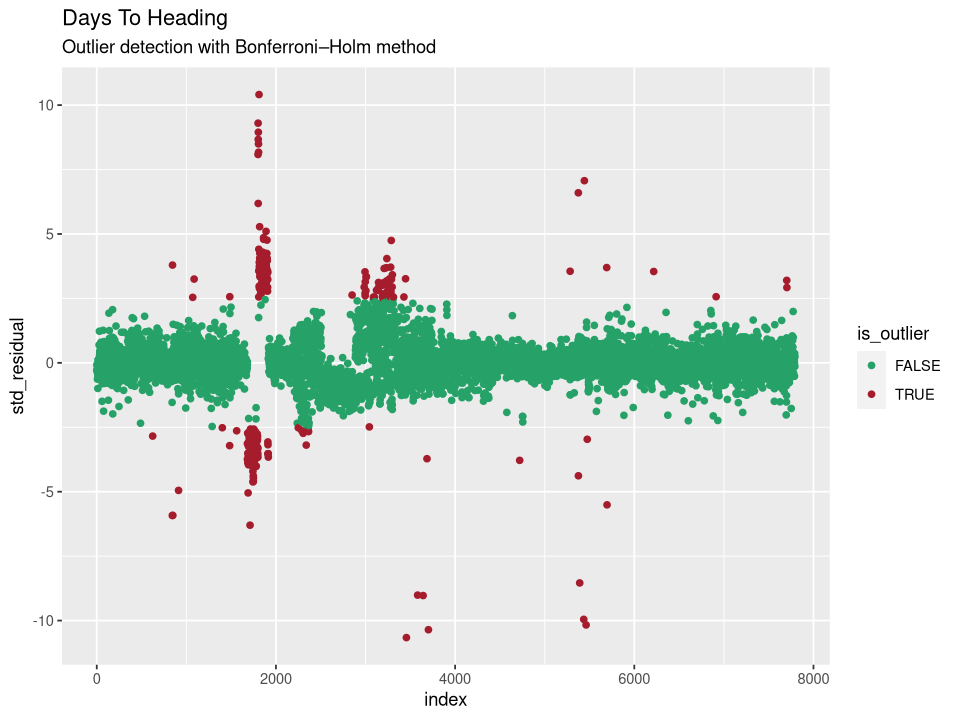

In [21]:
result_BH_HT <- make_BH_multtest(asreml_res_HT)

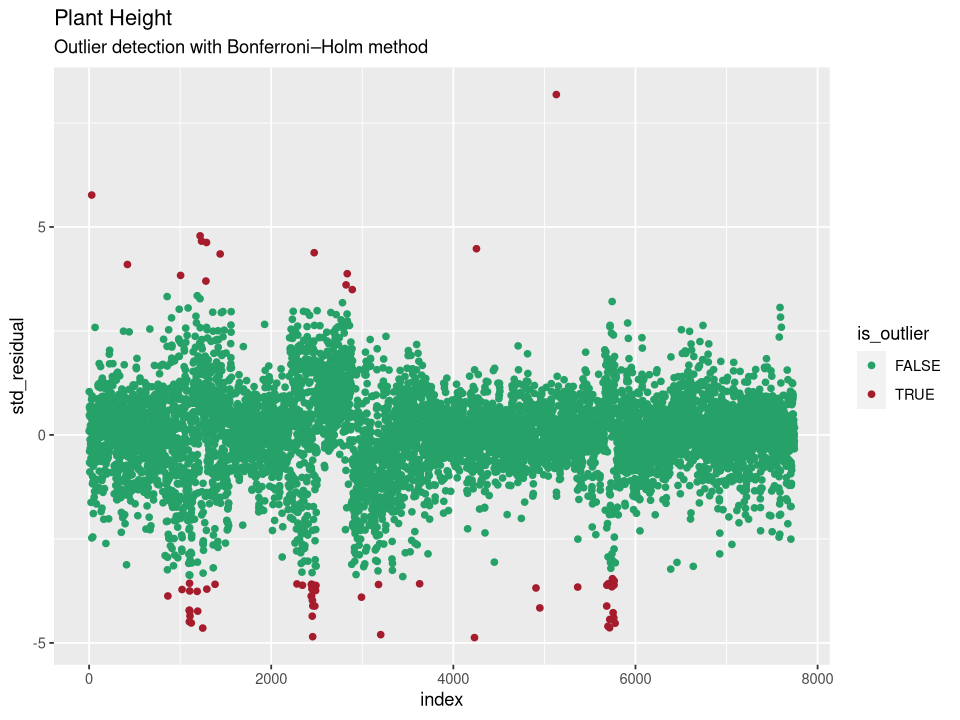

In [22]:
result_BH_PH <- make_BH_multtest(asreml_res_PH)

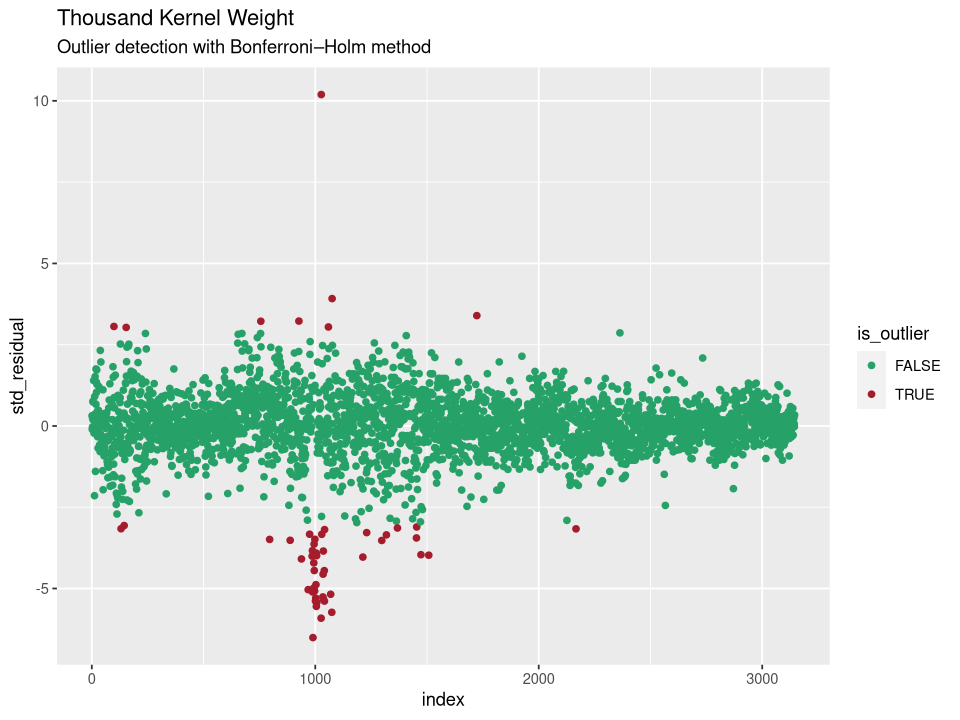

In [23]:
result_BH_TKW <- make_BH_multtest(asreml_res_TKW)

In [24]:
correct_II <- function(data_corrected_I, result_BH){
                        data_corrected_I[result_BH[which(!result_BH$is_outlier),"index"],] |> 
                        group_by(accenumb) |> filter(n() > 1) |> arrange(campaign) |> 
                        as.data.frame() |> droplevels()}

data_corrected_HT_II <- data_corrected_HT_I |> correct_II(result_BH_HT)
data_corrected_PH_II <- data_corrected_PH_I |> correct_II(result_BH_PH)
data_corrected_TKW_II <- data_corrected_TKW_I |> correct_II(result_BH_TKW)

## Calculate heritability

In [25]:
asreml_res_h_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:56 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -15549.45           1.0   7460 15:37:56    0.0
 2     -14375.10           1.0   7460 15:37:56    0.0
 3     -13783.51           1.0   7460 15:37:56    0.0
 4     -13455.84           1.0   7460 15:37:56    0.0
 5     -13313.70           1.0   7460 15:37:56    0.0
 6     -13289.21           1.0   7460 15:37:56    0.0
 7     -13287.20           1.0   7460 15:37:56    0.0
 8     -13286.99           1.0   7460 15:37:56    0.0
 9     -13286.94           1.0   7460 15:37:56    0.0
10     -13286.93           1.0   7460 15:37:56    0.0
11     -13286.92           1.0   7460 15:37:56    0.0
12     -13286.92           1.0   7460 15:37:56    0.0
13     -13286.92           1.0   7460 15:37:56    0.0


Warning message in asreml(days_to_heading ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”


In [26]:
asreml_res_h_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:56 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -26307.99           1.0   7680 15:37:56    0.0
 2     -25023.60           1.0   7680 15:37:56    0.0
 3     -24038.91           1.0   7680 15:37:56    0.0
 4     -23554.53           1.0   7680 15:37:56    0.0
 5     -23330.27           1.0   7680 15:37:56    0.0
 6     -23285.80           1.0   7680 15:37:56    0.0
 7     -23281.90           1.0   7680 15:37:56    0.0
 8     -23281.67           1.0   7680 15:37:56    0.0
 9     -23281.65           1.0   7680 15:37:56    0.0
10     -23281.64           1.0   7680 15:37:56    0.0
11     -23281.64           1.0   7680 15:37:56    0.0


In [27]:
asreml_res_h_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_TKW_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:56 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -7157.935           1.0   3084 15:37:56    0.0
 2     -6948.759           1.0   3084 15:37:56    0.0
 3     -6729.978           1.0   3084 15:37:56    0.0
 4     -6593.776           1.0   3084 15:37:56    0.0
 5     -6547.096           1.0   3084 15:37:56    0.0
 6     -6541.614           1.0   3084 15:37:56    0.0
 7     -6541.111           1.0   3084 15:37:56    0.0
 8     -6541.067           1.0   3084 15:37:56    0.0
 9     -6541.066           1.0   3084 15:37:56    0.0


In [28]:
get_quality <- function(trait, data_sub, asreml_res_h){
                varcomp <- summary(asreml_res_h)$varcomp
                var_G <- varcomp[2,"component"]
                var_E <- mean(varcomp[3:nrow(varcomp),"component"])
                no_campaigns <- mean(table(data_sub$accenumb[!is.na(data_sub[,trait])]))
                heritability <- var_G/(var_G+(var_E/no_campaigns))
                cat(colnames(data_sub)[3], "heritability:", round(heritability*100,1), "%")
                return(tibble(trait, heritability, var_G, var_E, no_campaigns))}

In [29]:
quality_HT <- get_quality("days_to_heading", data_sub_HT, asreml_res_h_HT)

days_to_heading heritability: 89.2 %

In [30]:
quality_PH <- get_quality("plant_height", data_sub_PH, asreml_res_h_PH)

plant_height heritability: 95.5 %

In [31]:
quality_TKW <- get_quality("thousand_kernel_weight", data_sub_TKW, asreml_res_h_TKW)

thousand_kernel_weight heritability: 84.9 %

In [32]:
quality_all = bind_rows(quality_HT, quality_PH, quality_TKW) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_all,"CREA_wheat_data_quality.csv")

## Run linear mixed model with outlier corrected data

In [33]:
asreml_data_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:37:56 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -11553.27           1.0   6132 15:37:57    0.7 (5 restrained)
 2     -11229.96           1.0   6132 15:37:57    0.5
 3     -10753.14           1.0   6132 15:37:58    0.5
 4     -10464.89           1.0   6132 15:37:58    0.5
 5     -10346.88           1.0   6132 15:37:59    0.5
 6     -10329.76           1.0   6132 15:37:59    0.5
 7     -10328.65           1.0   6132 15:38:00    0.5
 8     -10328.50           1.0   6132 15:38:00    0.5
 9     -10328.46           1.0   6132 15:38:01    0.5
10     -10328.45           1.0   6132 15:38:01    0.5
11     -10328.44           1.0   6132 15:38:02    0.5
12     -10328.44           1.0   6132 15:38:02    0.5
13     -10328.44           1.0   6132 15:38:02    0.5


Warning message in asreml(days_to_heading ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”


In [34]:
asreml_data_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:38:03 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -20306.88           1.0   6336 15:38:03    0.7 (4 restrained)
 2     -18884.19           1.0   6336 15:38:04    0.5
 3     -18661.93           1.0   6336 15:38:04    0.5
 4     -18551.67           1.0   6336 15:38:05    0.5
 5     -18516.21           1.0   6336 15:38:05    0.5
 6     -18511.91           1.0   6336 15:38:06    0.5
 7     -18511.45           1.0   6336 15:38:06    0.6
 8     -18511.36           1.0   6336 15:38:07    0.6
 9     -18511.34           1.0   6336 15:38:08    0.6
10     -18511.33           1.0   6336 15:38:08    0.5
11     -18511.33           1.0   6336 15:38:09    0.5
12     -18511.33           1.0   6336 15:38:09    0.5


In [35]:
asreml_data_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_TKW_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Thu Nov  9 15:38:09 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -4480.041           1.0   2115 15:38:09    0.3
 2     -4396.044           1.0   2115 15:38:10    0.2
 3     -4355.206           1.0   2115 15:38:10    0.2
 4     -4343.832           1.0   2115 15:38:10    0.2
 5     -4339.089           1.0   2115 15:38:10    0.2
 6     -4337.611           1.0   2115 15:38:10    0.2
 7     -4337.294           1.0   2115 15:38:10    0.2
 8     -4337.267           1.0   2115 15:38:11    0.2
 9     -4337.267           1.0   2115 15:38:11    0.2


## Extract BLUEs and create output file

In [36]:
get_BLUEs <- function(asreml_data){
                            intercept_index <- nrow(asreml_data$coeff$fixed)
                            intercept <- asreml_data$coeff$fixed[intercept_index]
                            BLUE <- asreml_data$coeff$fixed[-intercept_index,] + intercept
                            return(BLUE |> as.data.frame() |>
                                    rownames_to_column() |>
                                    mutate(genotype=str_split_i(rowname,"_", -1)) |> #assuming there is no underscore in the accession numbers
                                    select(genotype, BLUE))}

BLUEs_HT <- get_BLUEs(asreml_data_HT) |> rename("days_to_heading_BLUE"="BLUE")
BLUEs_PH <- get_BLUEs(asreml_data_PH) |> rename("plant_height_BLUE"="BLUE")
BLUEs_TKW <- get_BLUEs(asreml_data_TKW) |> rename("thousand_kernel_weight_BLUE"="BLUE")

BLUE_all <- genotypes |> left_join(BLUEs_HT, by="genotype") |> 
                        left_join(BLUEs_PH, by="genotype") |> 
                        left_join(BLUEs_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_all,"CREA_wheat_BLUE_values.csv")

In [37]:
library(rmarkdown)
convert_ipynb("CREA-CI_historic_wheat_data_analysis.ipynb")